# **Lab 4.2 NN MLP and CNN**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [16]:
def load_data(path, class_names):
    from torchvision import transforms
    from torchvision.datasets import ImageFolder
    from torch.utils.data import DataLoader, Subset
    import os

    # Apply transformations
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Pad(16,padding_mode='edge'),
        transforms.RandomRotation(45),
        transforms.CenterCrop(28),
    ])

    # Load full dataset to get class_to_idx mapping
    full_dataset = ImageFolder(root=path, transform=transform)
    class_to_idx = full_dataset.class_to_idx

    # Find indices for selected class names
    selected_class_indices = [class_to_idx[name] for name in class_names]

    # Create a mapping: original_label -> binary_label (0 or 1)
    label_map = {selected_class_indices[0]: 0, selected_class_indices[1]: 1}

    # Filter and remap labels
    def binary_label_filter(index):
        _, label = full_dataset[index]
        return label in label_map

    selected_indices = [idx for idx in range(len(full_dataset)) if binary_label_filter(idx)]

    # Wrap filtered subset and remap labels using target_transform
    filtered_dataset = Subset(
        ImageFolder(root=path, transform=transform, target_transform=lambda y: label_map[y]),
        selected_indices
    )

    # Split into train and test
    total_size = len(filtered_dataset)
    train_size = int(0.8 * total_size)
    test_size = total_size - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(filtered_dataset, [train_size, test_size])

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=80, shuffle=False)

    return train_loader, test_loader


Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

📃Train Dataset:
 	Number of images in class 0: 309
 	Number of images in class 1: 312
 	Number of training images: 621
📃Test Dataset:
 	Number of images in class 0: 79
 	Number of images in class 1: 77
 	Number of training images: 156


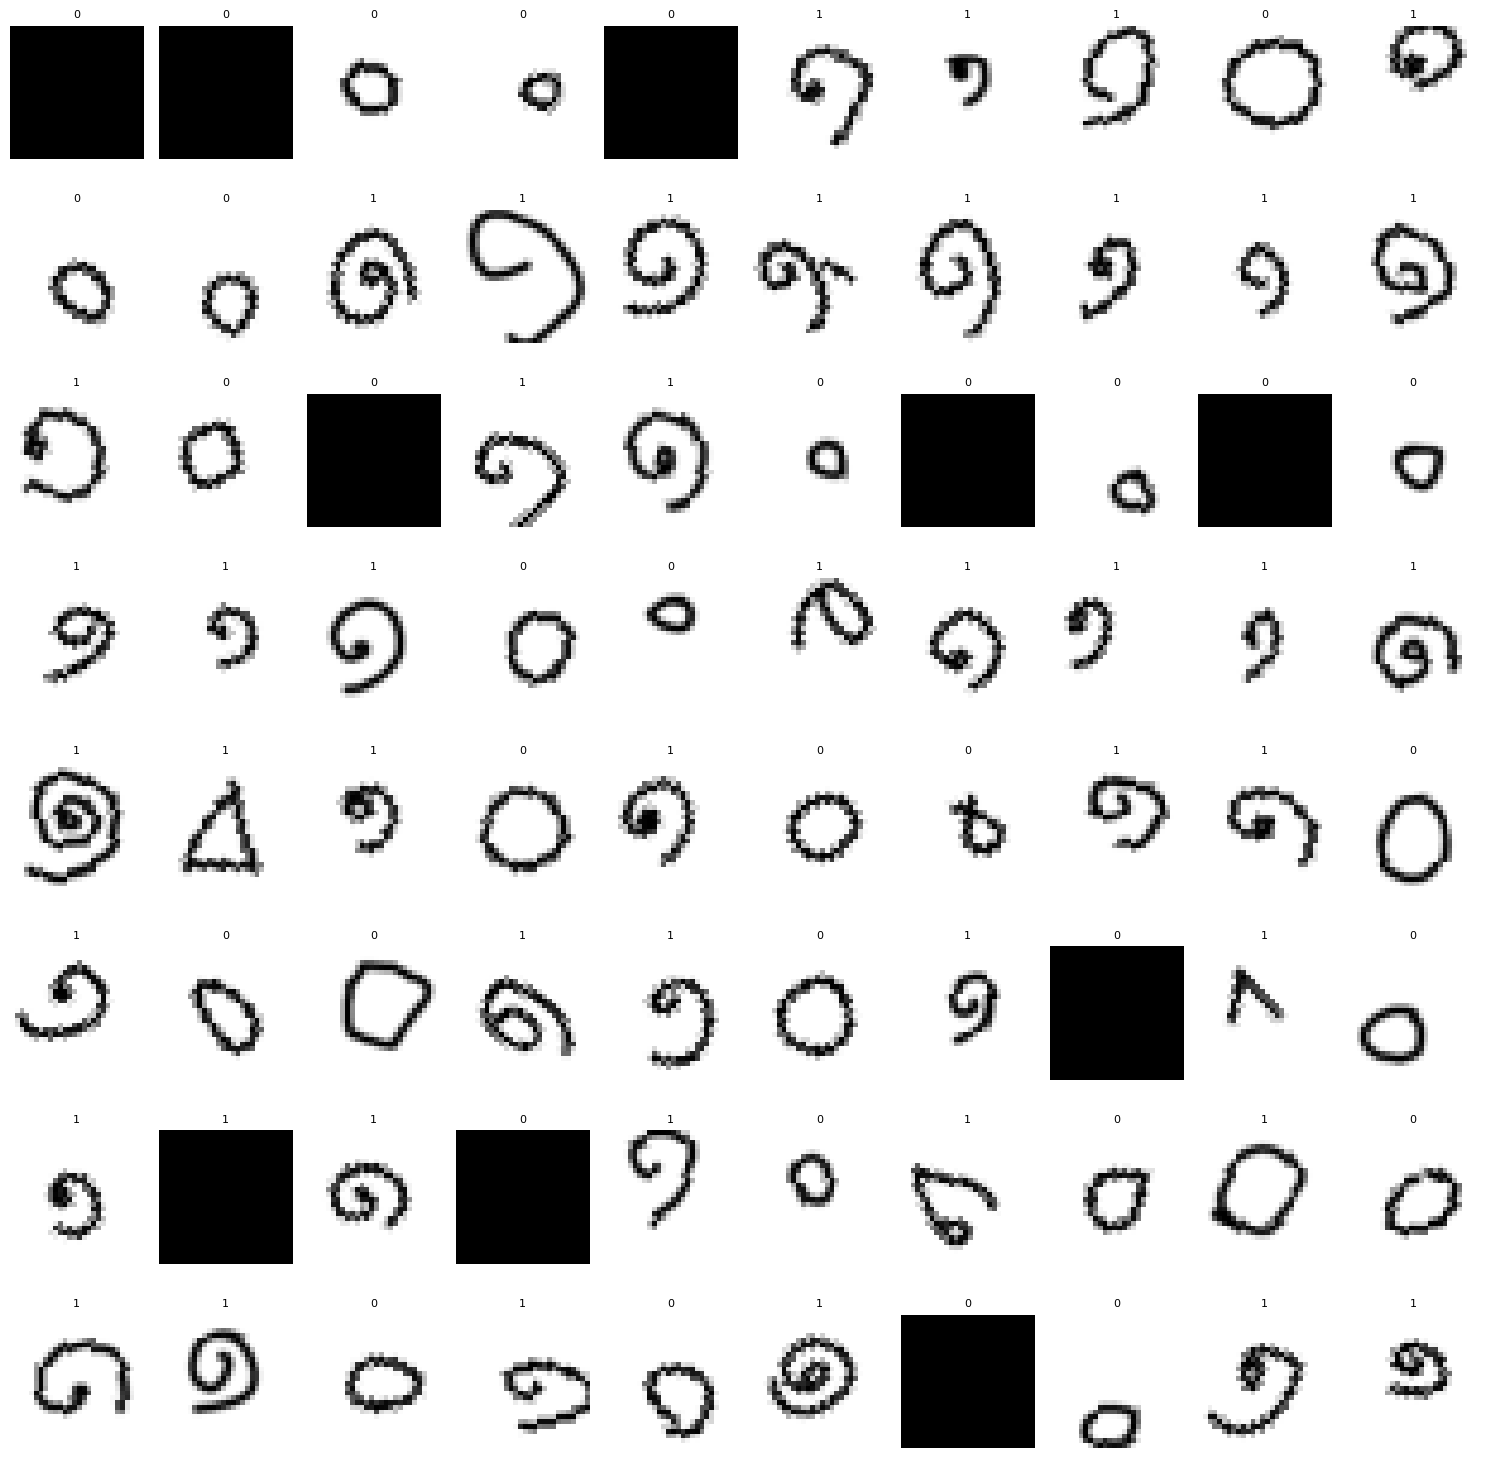

In [17]:
### START CODE HERE ###
class_names = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
train_loader, test_loader = load_data("thai-handwriting-number.appspot.com",class_names[:2])


labels = [train_loader.dataset.dataset[idx][1] for idx in train_loader.dataset.indices]
test_labels = [test_loader.dataset.dataset[idx][1] for idx in test_loader.dataset.indices]

num_class0 = len([x for x in labels if x == 0])
num_class1 = len([x for x in labels if x == 1])
print(f"📃Train Dataset:\n \tNumber of images in class 0: {num_class0}\n \tNumber of images in class 1: {num_class1}\n \tNumber of training images: {len(train_loader.dataset)}")

test_num_class0 = len([x for x in test_labels if x == 0])
test_num_class1 = len([x for x in test_labels if x == 1])
print(f"📃Test Dataset:\n \tNumber of images in class 0: {test_num_class0}\n \tNumber of images in class 1: {test_num_class1}\n \tNumber of training images: {len(test_loader.dataset)}")

images, labels = next(iter(train_loader))

# Plotting
test_images, test_labels = next(iter(test_loader))

batch_size = images.shape[0]
cols = 10
rows = batch_size // cols

plt.figure(figsize=(15, 15))
for i in range(batch_size):
    img = images[i].permute(1, 2, 0).numpy().clip(0, 1)
    label = class_names[labels[i]]
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img,cmap='gray')
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()
### END CODE HERE ###

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

In [18]:
### START CODE HERE ###
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc = nn.Linear(28 * 28, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = {}
        out["input"] = x

        x = x.view(x.size(0), -1)  # Flatten
        out["flatten"] = x

        x = self.fc(x)
        out["fc"] = x

        x = self.sigmoid(x)
        out["output"] = x

        return out

# Multi-Layer Perceptron (Two FC layers)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = {}
        out["input"] = x

        x = x.view(x.size(0), -1)  # Flatten
        out["flatten"] = x

        x = self.fc1(x)
        out["fc1"] = x

        x = self.relu(x)
        out["relu_fc1"] = x

        x = self.fc2(x)
        out["fc2"] = x

        x = self.sigmoid(x)
        out["output"] = x

        return out

# Convolutional Neural Network (unchanged structure, just matching output style)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = {}
        out["input"] = x

        x = self.conv1(x)
        out["conv1"] = x

        x = self.relu(x)
        out["relu1"] = x
        x = self.conv2(x)
        out["conv2"] = x

        x = self.relu(x)
        out["relu2"] = x

        x = x.view(x.size(0), -1)
        out["flatten"] = x

        x = self.fc1(x)
        out["fc1"] = x

        x = self.relu(x)
        out["relu_fc1"] = x

        x = self.fc2(x)
        out["fc2"] = x

        x = self.sigmoid(x)
        out["output"] = x

        return out
### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [57]:
def show_featuremaps(features, title="Feature Output"):
    """
    Visualizes feature maps or outputs from CNN layers with custom format:
      - Conv layers: channels stacked vertically
      - Flattened layers (1D, 2D): image stacked vertically, stretched width
      - Scalar outputs: color patch in viridis colormap

    Shows only the first sample in the batch.
    """
    layers = list(features.keys())
    num_layers = len(layers)

    fig, axs = plt.subplots(1,num_layers , figsize=(20, 12))
    if num_layers == 1:
        axs = [axs]

    fig.suptitle(title, fontsize=16)
    for idx, (layer_name, feats) in enumerate(features.items()):
        feats = feats[0].clone().detach().cpu()  # Only the first sample
        ax = axs[idx]
        ax.set_title(layer_name, fontsize=10)

        if feats.ndim == 3:  # Conv: (C, H, W)
            C = feats.shape[0]
            stacked = torch.cat([feats[i] for i in range(C)], dim=0)  # vertical concat (stack height-wise)
            im = ax.imshow(stacked.numpy(), cmap='viridis')
            ax.axis('off')

        elif feats.ndim == 1:  # FC layer or flattened
            im = ax.imshow(feats.unsqueeze(1).numpy(), aspect='auto', cmap='viridis')
            ax.set_ylabel("Index")
            ax.set_xticks([])
            ax.set_yticks([])

        elif feats.ndim == 2 and feats.shape[1] == 1:  # Scalar output
            val = feats[0].item()
            im = ax.imshow([[val]], cmap='viridis', vmin=0, vmax=1,aspect='auto')
            ax.axis('off')

        else:
            ax.text(0.5, 0.5, f"Unsupported shape: {feats.shape}", ha='center', va='center')
            ax.axis('off')

    plt.tight_layout()
    return fig


TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [46]:
def train(class_names, model, opt, loss_fn, train_loader, test_loader, epochs=10,
          writer=None, checkpoint_path=None, device='cpu'):

    import matplotlib.pyplot as plt
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            outputs = model(inputs)["output"]
            loss = loss_fn(outputs.view(-1), targets.float())
            loss.backward()
            opt.step()

            train_loss += loss.item() * inputs.size(0)
            preds = (outputs.view(-1) > 0.5).int()
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Evaluation
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)["output"]
                
                loss = loss_fn(outputs.view(-1), targets.float())
                test_loss += loss.item() * inputs.size(0)
                preds = (outputs.view(-1) > 0.5).int()
                correct += (preds == targets).sum().item()
                total += targets.size(0)

        avg_test_loss = test_loss / total
        test_acc = correct / total

        # Logging to TensorBoard
        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/Test', avg_test_loss, epoch)
            writer.add_scalar('Accuracy/Train', train_acc, epoch)
            writer.add_scalar('Accuracy/Test', test_acc, epoch)

            # Feature maps
            try:
                inputs, _ = next(iter(test_loader))
                inputs = inputs.to(device)

                features = model(inputs)  # returns dict
                fig = show_featuremaps(features)
                if fig:
                    writer.add_figure("FeatureMaps/AllLayers", fig, global_step=epoch)
                    plt.close(fig)
            except Exception as e:
                print(f"⚠️ Couldn't extract or plot feature maps: {e}")

            print(f"✅ Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")

    if checkpoint_path:
        torch.save(model.state_dict(), checkpoint_path)
        print(f"💾 Model saved to {checkpoint_path}")


Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [58]:
### START CODE HERE ###
import torch.optim as optim
from itertools import combinations

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.BCELoss()

# Map model names to their classes
model_classes = {
    'nn': NN,
    'mlp': MLP,
    'cnn': CNN,
}
digit_pairs = list(combinations(range(10), 2))
class_a = 0
class_b = 1
# for (class_a, class_b) in digit_pairs:
print(f"\n--- Training for pair: {class_a} vs {class_b} ---")

# Load dataset filtered by the current pair of classes
# Make sure load_data accepts a list of class names as strings, so:
classes_for_pair = [str(class_a), str(class_b)]
train_loader, test_loader = load_data("thai-handwriting-number.appspot.com", classes_for_pair)

for name, ModelClass in model_classes.items():
    print(f"Training model: {name.upper()} on classes {class_a} vs {class_b}")
    
    writer = SummaryWriter(log_dir=f'runs/{class_a}_vs_{class_b}_{name}')
    model = ModelClass().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train(
        class_names=classes_for_pair,
        model=model,
        opt=optimizer,
        loss_fn=loss_fn,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=8,
        writer=writer,
        checkpoint_path=f'checkpoints/{class_a}_vs_{class_b}_{name}.pth',
        device=device
    )
    
    writer.close()


### END CODE HERE ###


--- Training for pair: 0 vs 1 ---
Training model: NN on classes 0 vs 1


Epoch 1/8: 100%|██████████| 8/8 [00:01<00:00,  7.96it/s]


✅ Epoch 1/8 | Train Loss: 0.7177, Train Acc: 0.4831 | Test Loss: 0.7090, Test Acc: 0.5128


Epoch 2/8: 100%|██████████| 8/8 [00:00<00:00,  8.05it/s]


✅ Epoch 2/8 | Train Loss: 0.6932, Train Acc: 0.5185 | Test Loss: 0.6855, Test Acc: 0.5064


Epoch 3/8: 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]


✅ Epoch 3/8 | Train Loss: 0.6796, Train Acc: 0.5604 | Test Loss: 0.6697, Test Acc: 0.6731


Epoch 4/8: 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]


✅ Epoch 4/8 | Train Loss: 0.6649, Train Acc: 0.6232 | Test Loss: 0.6551, Test Acc: 0.6731


Epoch 5/8: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


✅ Epoch 5/8 | Train Loss: 0.6547, Train Acc: 0.6860 | Test Loss: 0.6611, Test Acc: 0.6795


Epoch 6/8: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]


✅ Epoch 6/8 | Train Loss: 0.6470, Train Acc: 0.7053 | Test Loss: 0.6525, Test Acc: 0.6410


Epoch 7/8: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


✅ Epoch 7/8 | Train Loss: 0.6358, Train Acc: 0.7005 | Test Loss: 0.6273, Test Acc: 0.7244


Epoch 8/8: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


✅ Epoch 8/8 | Train Loss: 0.6313, Train Acc: 0.7085 | Test Loss: 0.6248, Test Acc: 0.6987
💾 Model saved to checkpoints/0_vs_1_nn.pth
Training model: MLP on classes 0 vs 1


Epoch 1/8: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]


✅ Epoch 1/8 | Train Loss: 0.7812, Train Acc: 0.5008 | Test Loss: 0.7126, Test Acc: 0.5128


Epoch 2/8: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


✅ Epoch 2/8 | Train Loss: 0.7050, Train Acc: 0.4686 | Test Loss: 0.7017, Test Acc: 0.4872


Epoch 3/8: 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]


✅ Epoch 3/8 | Train Loss: 0.6912, Train Acc: 0.5153 | Test Loss: 0.6856, Test Acc: 0.6795


Epoch 4/8: 100%|██████████| 8/8 [00:00<00:00,  8.35it/s]


✅ Epoch 4/8 | Train Loss: 0.6859, Train Acc: 0.5652 | Test Loss: 0.6821, Test Acc: 0.5513


Epoch 5/8: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


✅ Epoch 5/8 | Train Loss: 0.6803, Train Acc: 0.6232 | Test Loss: 0.6823, Test Acc: 0.4936


Epoch 6/8: 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


✅ Epoch 6/8 | Train Loss: 0.6768, Train Acc: 0.6329 | Test Loss: 0.6766, Test Acc: 0.6987


Epoch 7/8: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


✅ Epoch 7/8 | Train Loss: 0.6717, Train Acc: 0.6957 | Test Loss: 0.6672, Test Acc: 0.6538


Epoch 8/8: 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]


✅ Epoch 8/8 | Train Loss: 0.6668, Train Acc: 0.6957 | Test Loss: 0.6637, Test Acc: 0.7244
💾 Model saved to checkpoints/0_vs_1_mlp.pth
Training model: CNN on classes 0 vs 1


Epoch 1/8: 100%|██████████| 8/8 [00:01<00:00,  6.66it/s]


✅ Epoch 1/8 | Train Loss: 0.7646, Train Acc: 0.4847 | Test Loss: 0.6970, Test Acc: 0.5128


Epoch 2/8: 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]


✅ Epoch 2/8 | Train Loss: 0.6868, Train Acc: 0.5829 | Test Loss: 0.6734, Test Acc: 0.6346


Epoch 3/8: 100%|██████████| 8/8 [00:01<00:00,  6.67it/s]


✅ Epoch 3/8 | Train Loss: 0.6526, Train Acc: 0.7037 | Test Loss: 0.6191, Test Acc: 0.7308


Epoch 4/8: 100%|██████████| 8/8 [00:01<00:00,  6.59it/s]


✅ Epoch 4/8 | Train Loss: 0.5849, Train Acc: 0.7713 | Test Loss: 0.5274, Test Acc: 0.7756


Epoch 5/8: 100%|██████████| 8/8 [00:01<00:00,  6.80it/s]


✅ Epoch 5/8 | Train Loss: 0.4944, Train Acc: 0.7762 | Test Loss: 0.5279, Test Acc: 0.7564


Epoch 6/8: 100%|██████████| 8/8 [00:01<00:00,  6.52it/s]


✅ Epoch 6/8 | Train Loss: 0.4458, Train Acc: 0.8019 | Test Loss: 0.4888, Test Acc: 0.7949


Epoch 7/8: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


✅ Epoch 7/8 | Train Loss: 0.4195, Train Acc: 0.7987 | Test Loss: 0.4144, Test Acc: 0.8333


Epoch 8/8: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s]


✅ Epoch 8/8 | Train Loss: 0.3932, Train Acc: 0.8454 | Test Loss: 0.4461, Test Acc: 0.8013
💾 Model saved to checkpoints/0_vs_1_cnn.pth


Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>


--- Evaluating pair 0 vs 1 ---
Evaluating NN on 0 vs 1


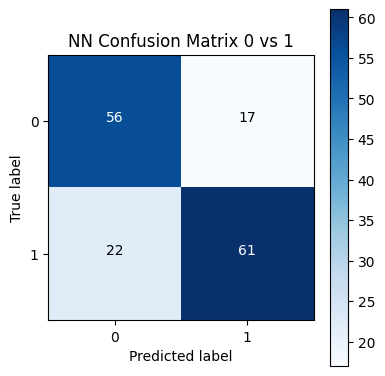

Evaluating MLP on 0 vs 1


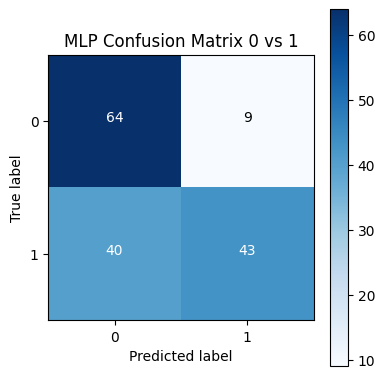

Evaluating CNN on 0 vs 1


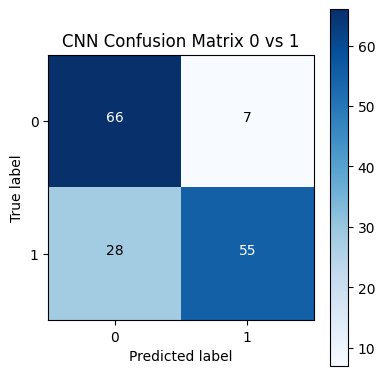


--- Evaluating pair 0 vs 2 ---
Evaluating NN on 0 vs 2


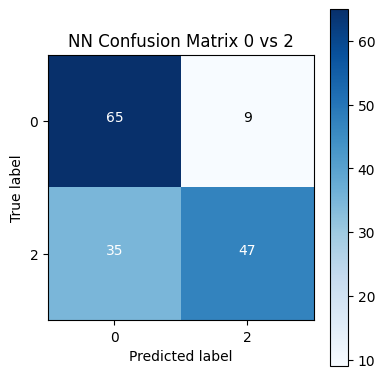

Evaluating MLP on 0 vs 2


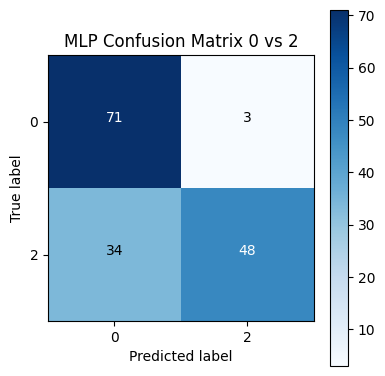

Evaluating CNN on 0 vs 2


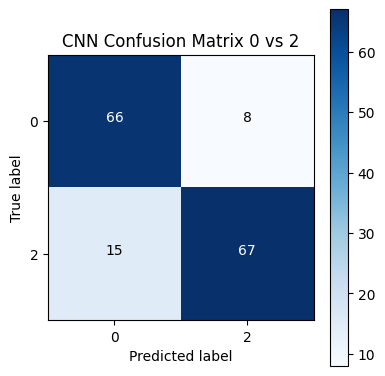


--- Evaluating pair 0 vs 3 ---
Evaluating NN on 0 vs 3


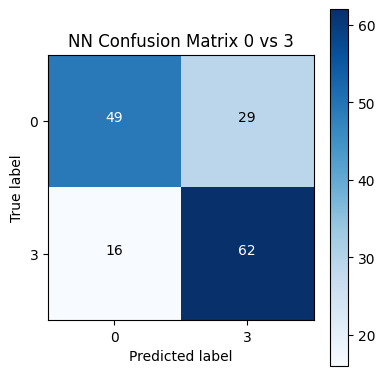

Evaluating MLP on 0 vs 3


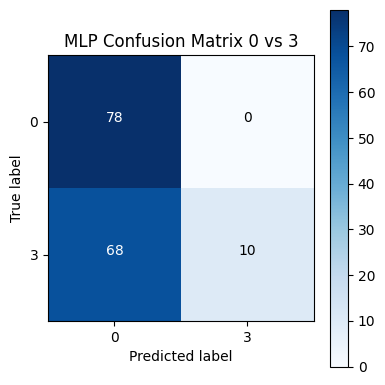

Evaluating CNN on 0 vs 3


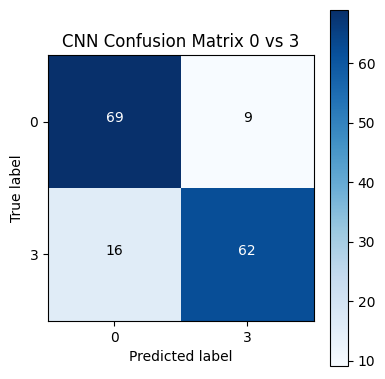


--- Evaluating pair 0 vs 4 ---
Evaluating NN on 0 vs 4


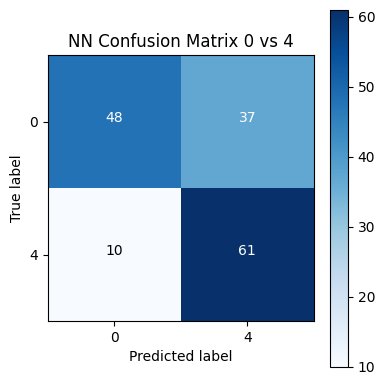

Evaluating MLP on 0 vs 4


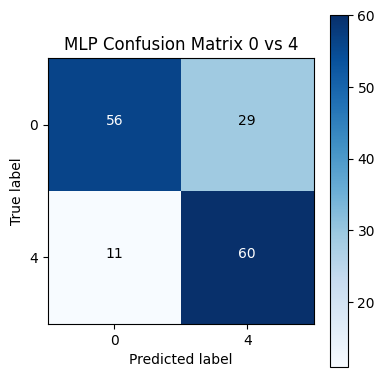

Evaluating CNN on 0 vs 4


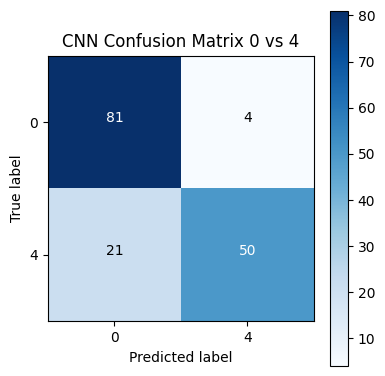


--- Evaluating pair 0 vs 5 ---
Evaluating NN on 0 vs 5


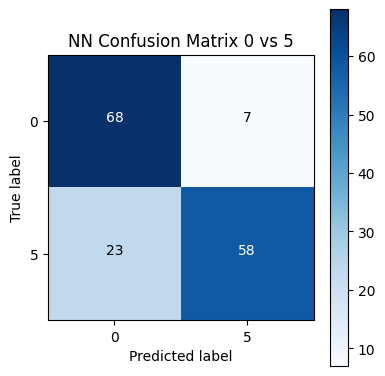

Evaluating MLP on 0 vs 5


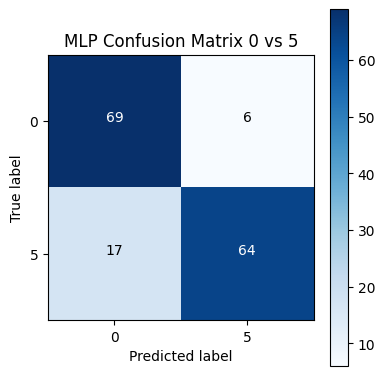

Evaluating CNN on 0 vs 5


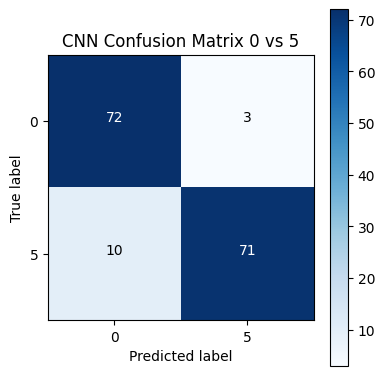


--- Evaluating pair 0 vs 6 ---
Evaluating NN on 0 vs 6


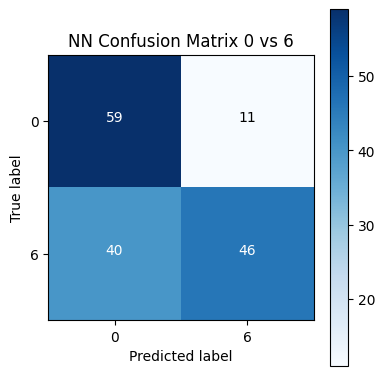

Evaluating MLP on 0 vs 6


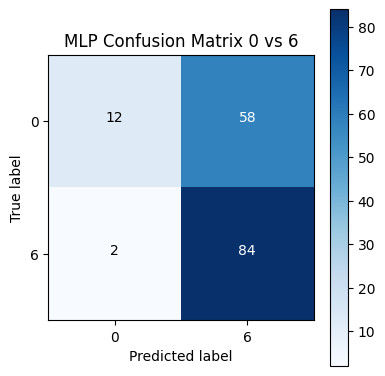

Evaluating CNN on 0 vs 6


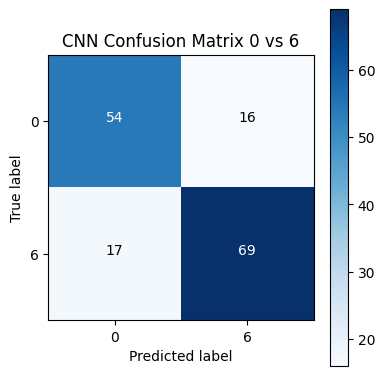


--- Evaluating pair 0 vs 7 ---
Evaluating NN on 0 vs 7


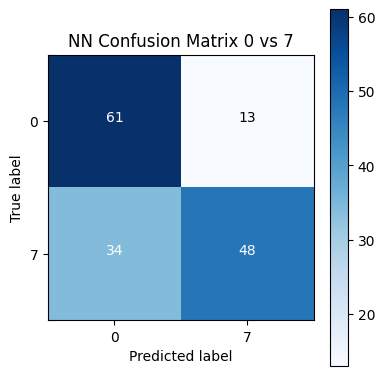

Evaluating MLP on 0 vs 7


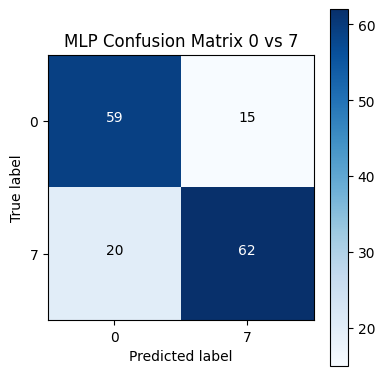

Evaluating CNN on 0 vs 7


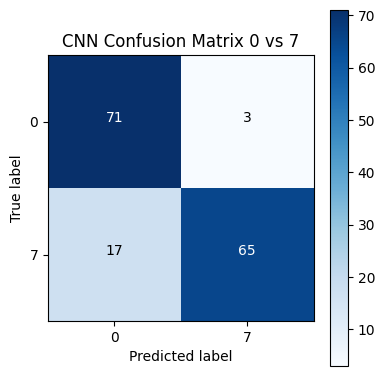


--- Evaluating pair 0 vs 8 ---
Evaluating NN on 0 vs 8


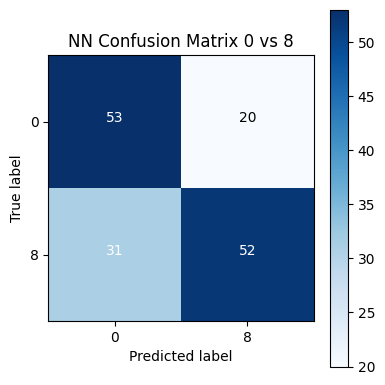

Evaluating MLP on 0 vs 8


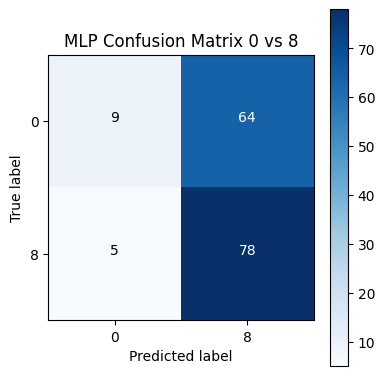

Evaluating CNN on 0 vs 8


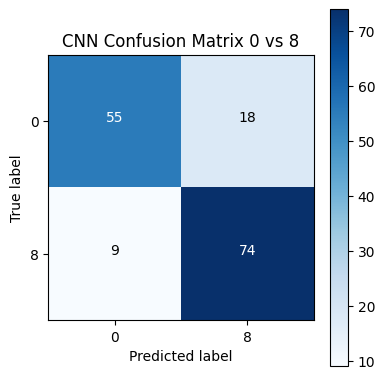


--- Evaluating pair 0 vs 9 ---
Evaluating NN on 0 vs 9


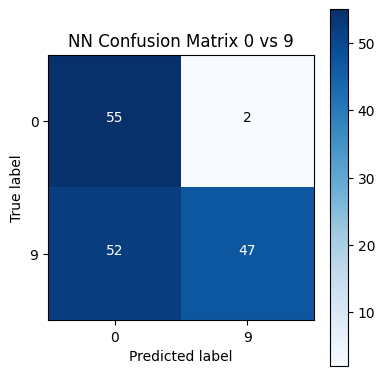

Evaluating MLP on 0 vs 9


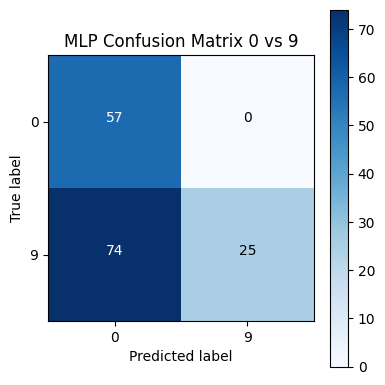

Evaluating CNN on 0 vs 9


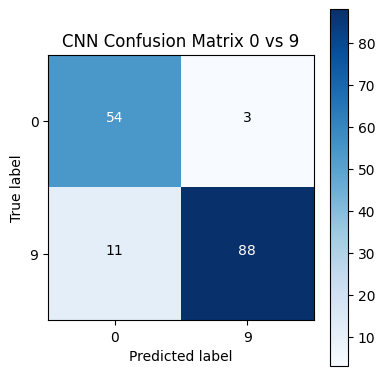


--- Evaluating pair 1 vs 2 ---
Evaluating NN on 1 vs 2


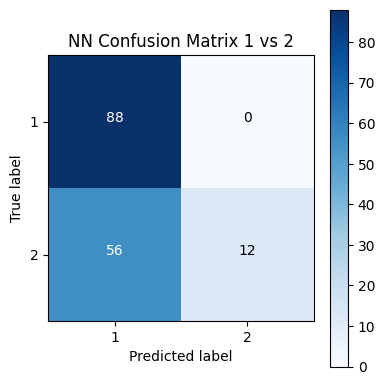

Evaluating MLP on 1 vs 2


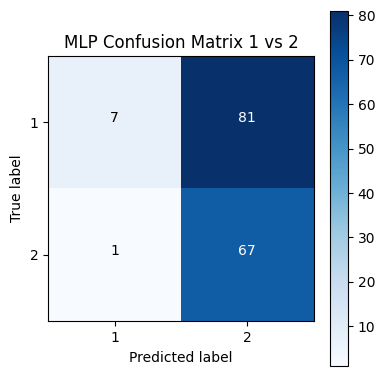

Evaluating CNN on 1 vs 2


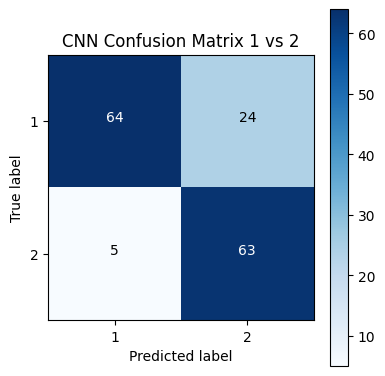


--- Evaluating pair 1 vs 3 ---
Evaluating NN on 1 vs 3


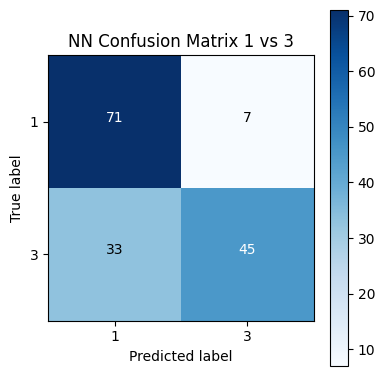

Evaluating MLP on 1 vs 3


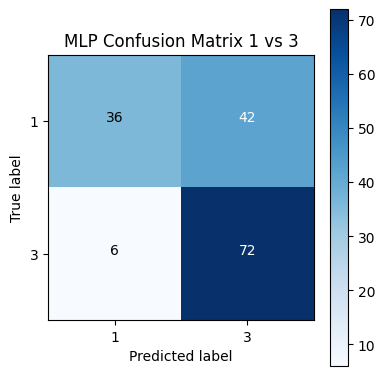

Evaluating CNN on 1 vs 3


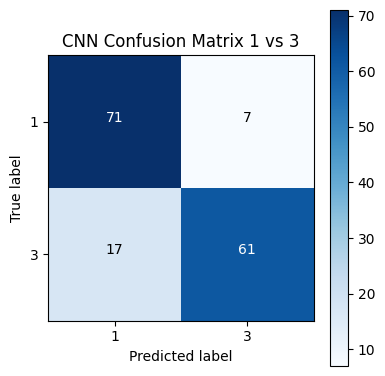


--- Evaluating pair 1 vs 4 ---
Evaluating NN on 1 vs 4


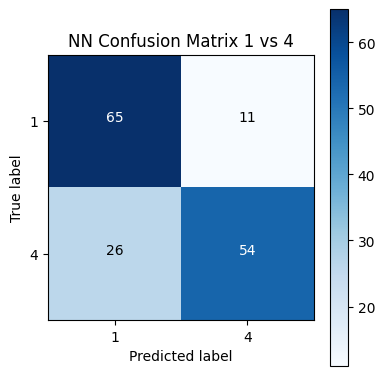

Evaluating MLP on 1 vs 4


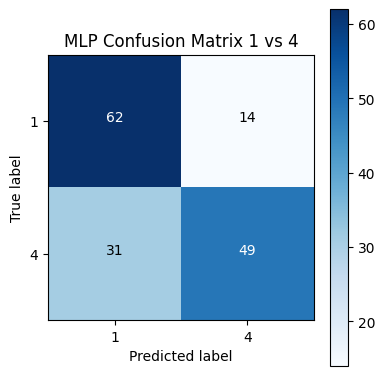

Evaluating CNN on 1 vs 4


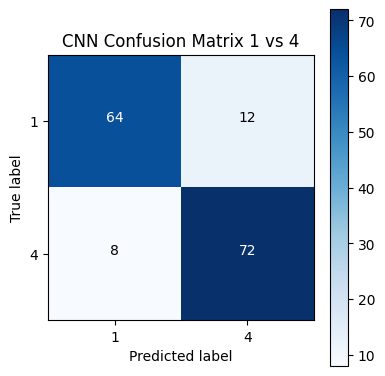


--- Evaluating pair 1 vs 5 ---
Evaluating NN on 1 vs 5


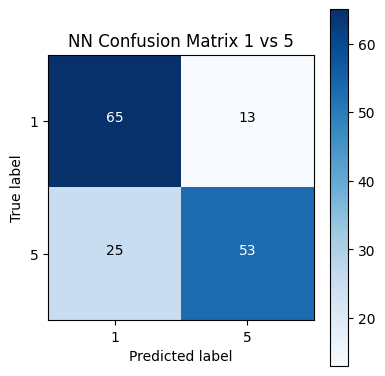

Evaluating MLP on 1 vs 5


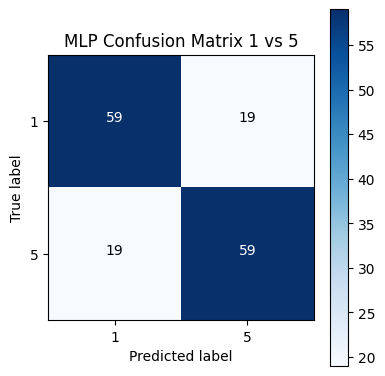

Evaluating CNN on 1 vs 5


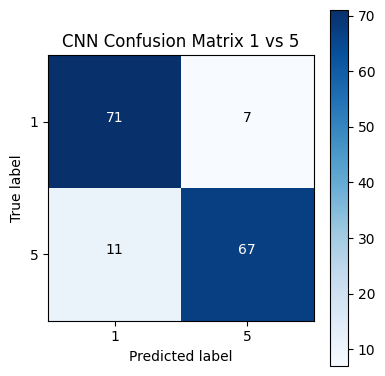


--- Evaluating pair 1 vs 6 ---
Evaluating NN on 1 vs 6


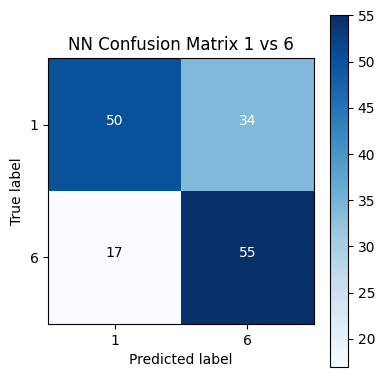

Evaluating MLP on 1 vs 6


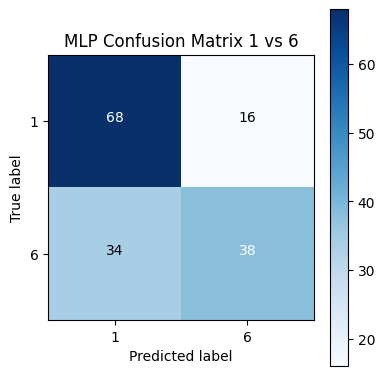

Evaluating CNN on 1 vs 6


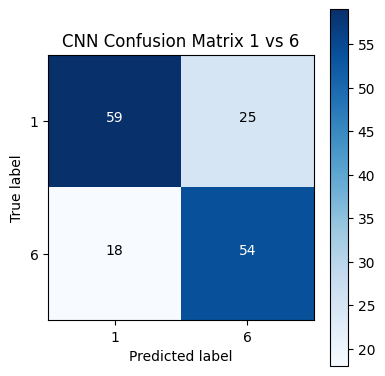


--- Evaluating pair 1 vs 7 ---
Evaluating NN on 1 vs 7


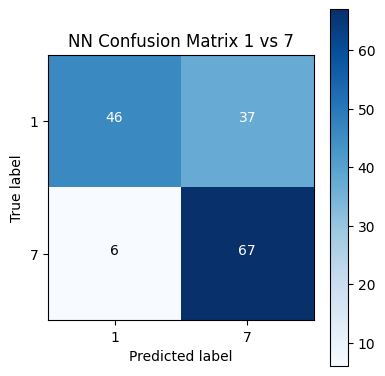

Evaluating MLP on 1 vs 7


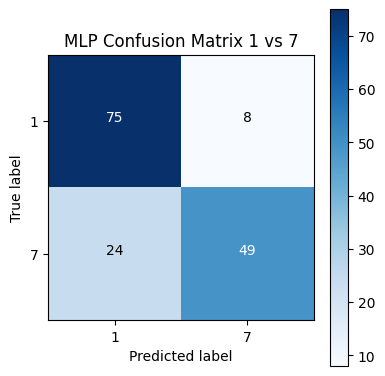

Evaluating CNN on 1 vs 7


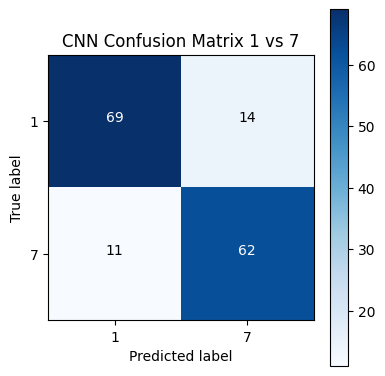


--- Evaluating pair 1 vs 8 ---
Evaluating NN on 1 vs 8


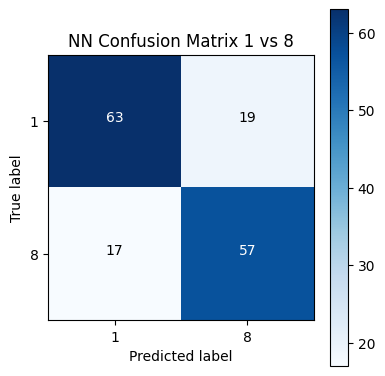

Evaluating MLP on 1 vs 8


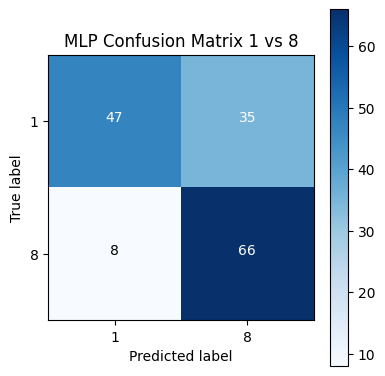

Evaluating CNN on 1 vs 8


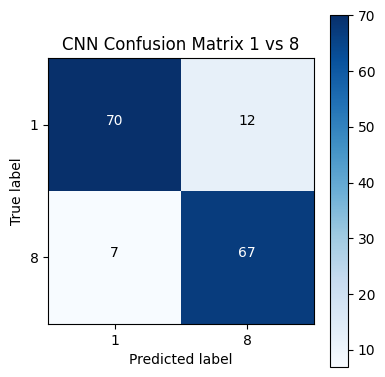


--- Evaluating pair 1 vs 9 ---
Evaluating NN on 1 vs 9


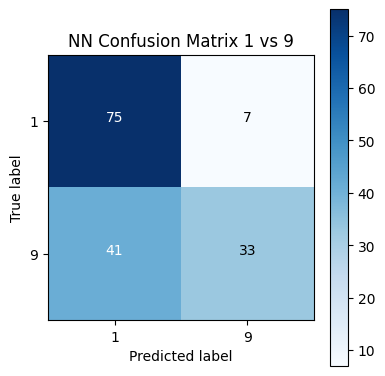

Evaluating MLP on 1 vs 9


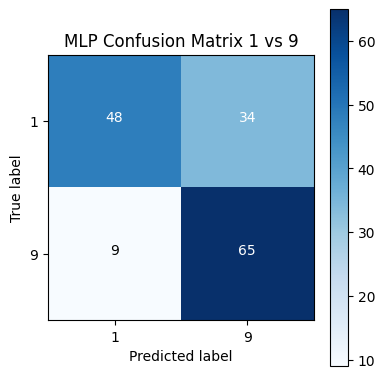

Evaluating CNN on 1 vs 9


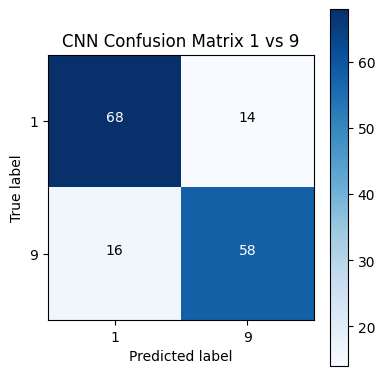


--- Evaluating pair 2 vs 3 ---
Evaluating NN on 2 vs 3


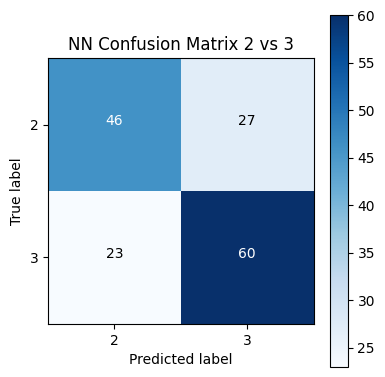

Evaluating MLP on 2 vs 3


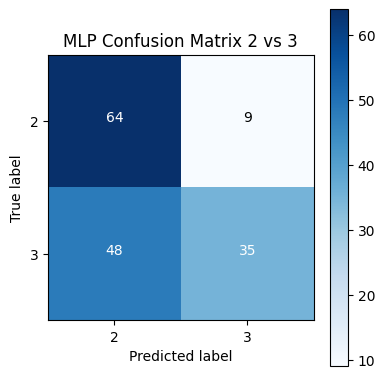

Evaluating CNN on 2 vs 3


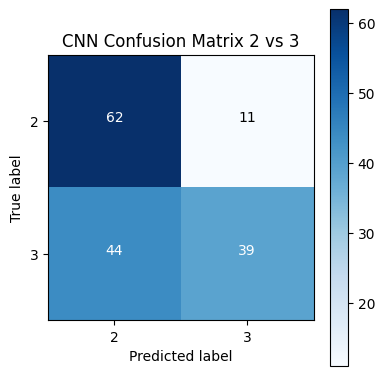


--- Evaluating pair 2 vs 4 ---
Evaluating NN on 2 vs 4


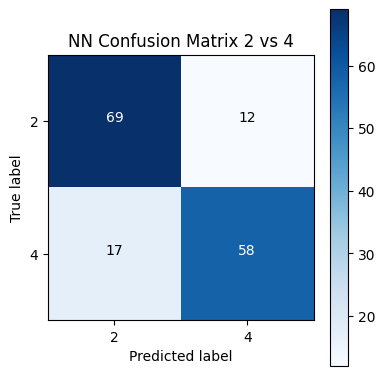

Evaluating MLP on 2 vs 4


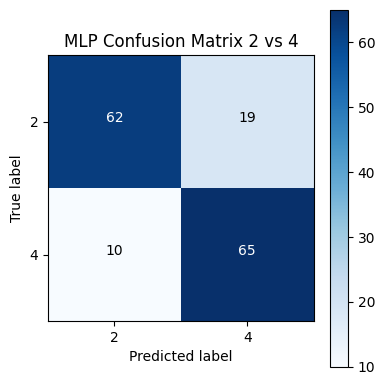

Evaluating CNN on 2 vs 4


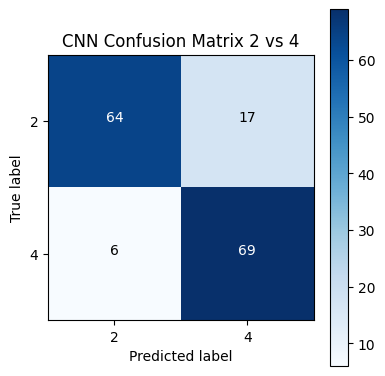


--- Evaluating pair 2 vs 5 ---
Evaluating NN on 2 vs 5


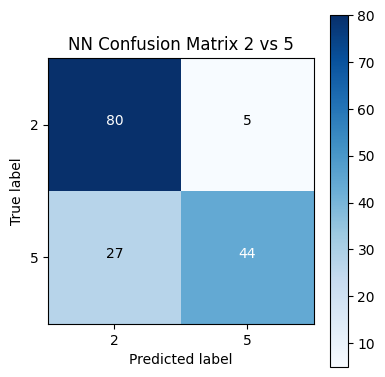

Evaluating MLP on 2 vs 5


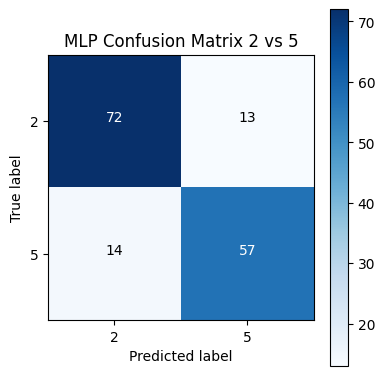

Evaluating CNN on 2 vs 5


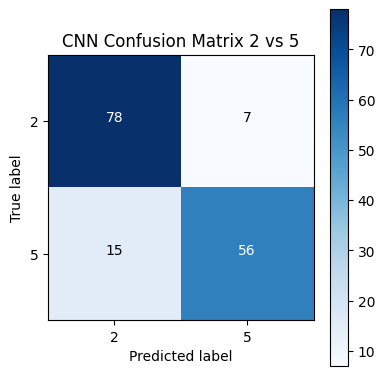


--- Evaluating pair 2 vs 6 ---
Evaluating NN on 2 vs 6


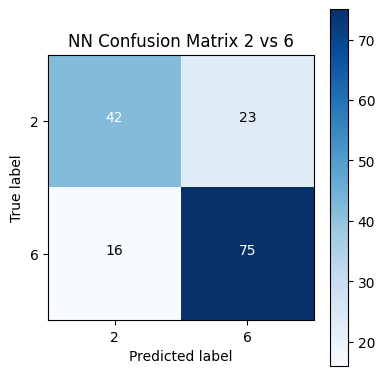

Evaluating MLP on 2 vs 6


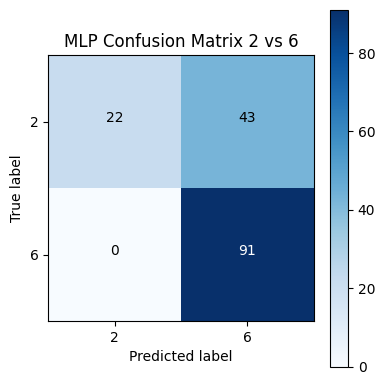

Evaluating CNN on 2 vs 6


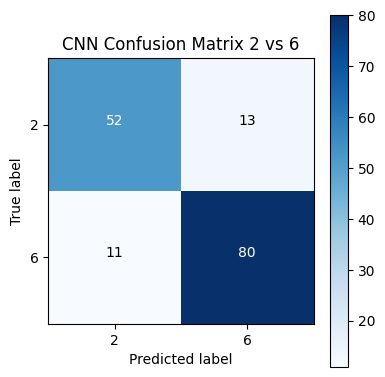


--- Evaluating pair 2 vs 7 ---
Evaluating NN on 2 vs 7


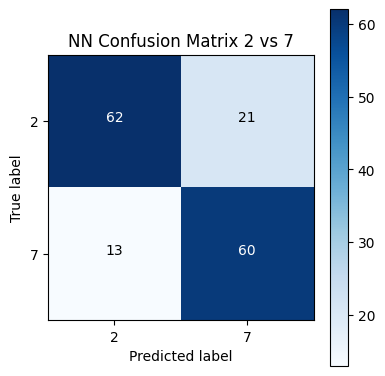

Evaluating MLP on 2 vs 7


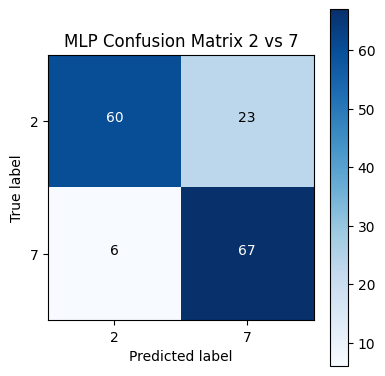

Evaluating CNN on 2 vs 7


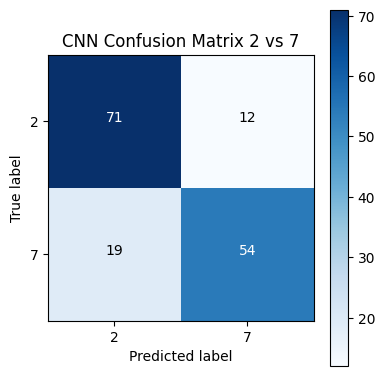


--- Evaluating pair 2 vs 8 ---
Evaluating NN on 2 vs 8


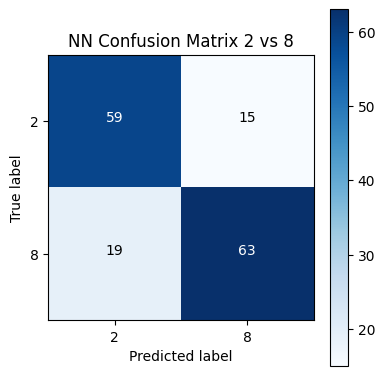

Evaluating MLP on 2 vs 8


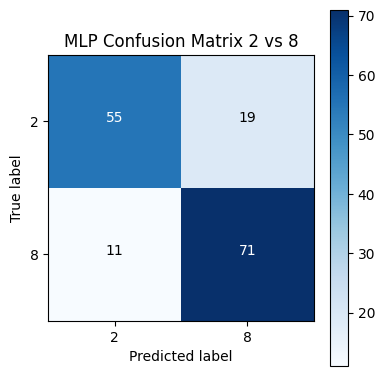

Evaluating CNN on 2 vs 8


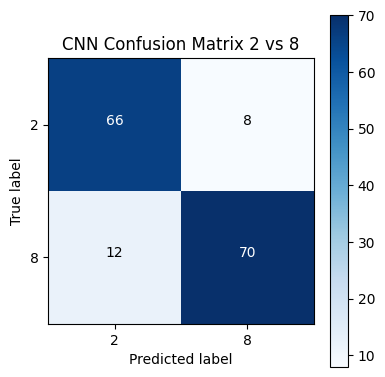


--- Evaluating pair 2 vs 9 ---
Evaluating NN on 2 vs 9


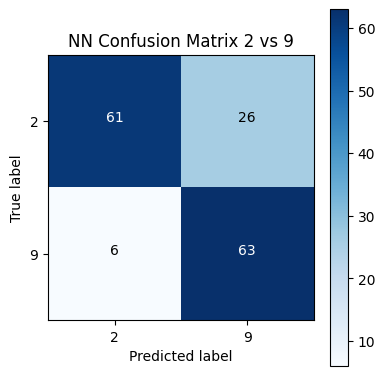

Evaluating MLP on 2 vs 9


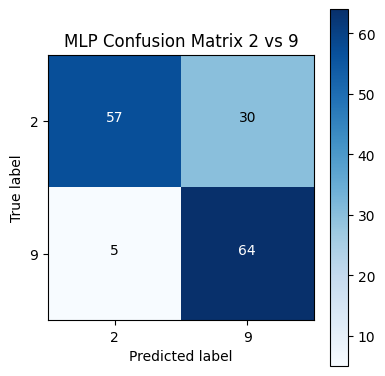

Evaluating CNN on 2 vs 9


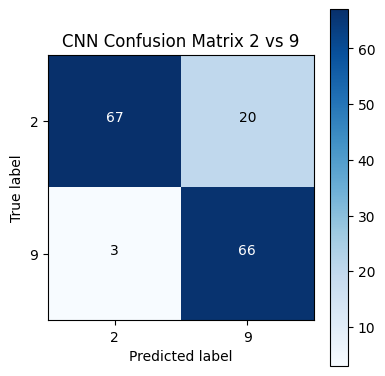


--- Evaluating pair 3 vs 4 ---
Evaluating NN on 3 vs 4


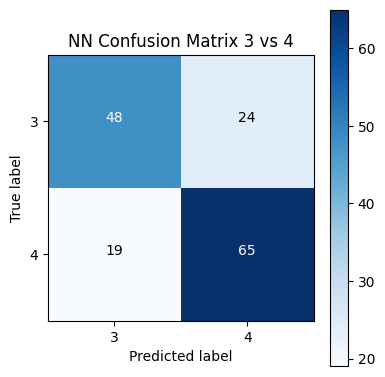

Evaluating MLP on 3 vs 4


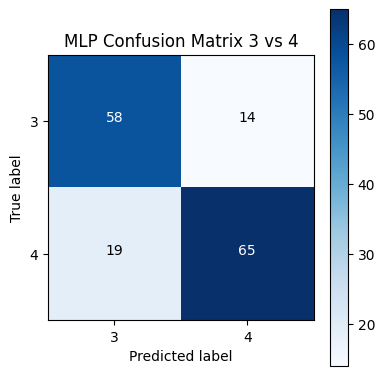

Evaluating CNN on 3 vs 4


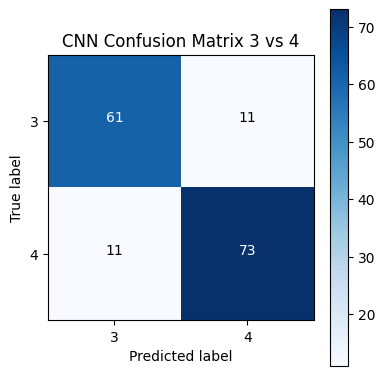


--- Evaluating pair 3 vs 5 ---
Evaluating NN on 3 vs 5


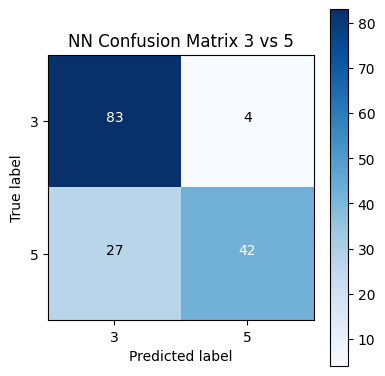

Evaluating MLP on 3 vs 5


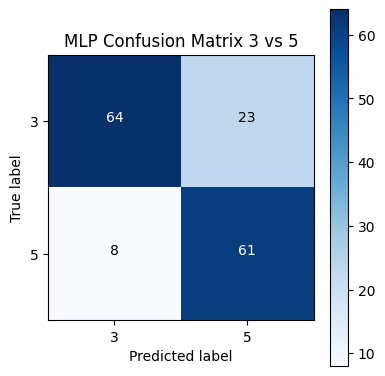

Evaluating CNN on 3 vs 5


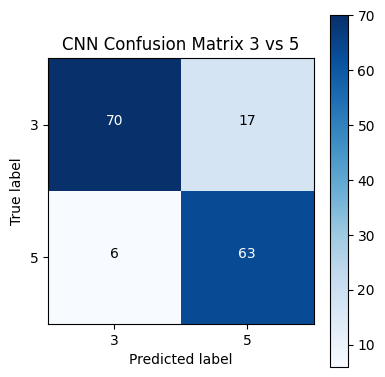


--- Evaluating pair 3 vs 6 ---
Evaluating NN on 3 vs 6


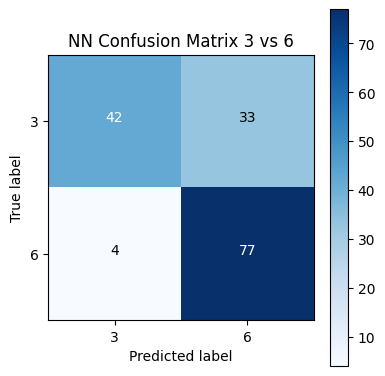

Evaluating MLP on 3 vs 6


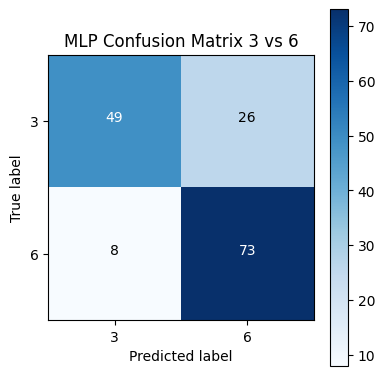

Evaluating CNN on 3 vs 6


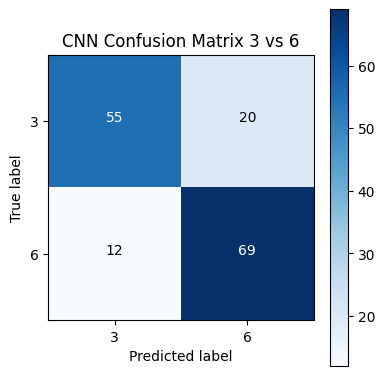


--- Evaluating pair 3 vs 7 ---
Evaluating NN on 3 vs 7


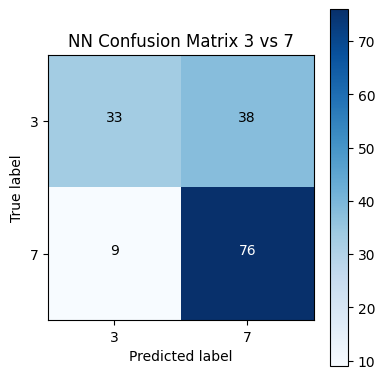

Evaluating MLP on 3 vs 7


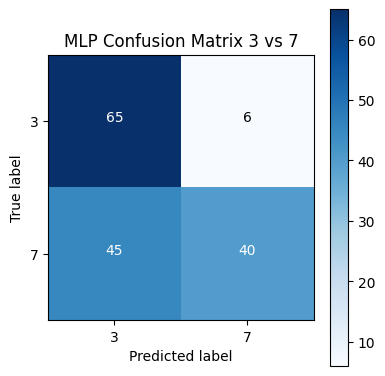

Evaluating CNN on 3 vs 7


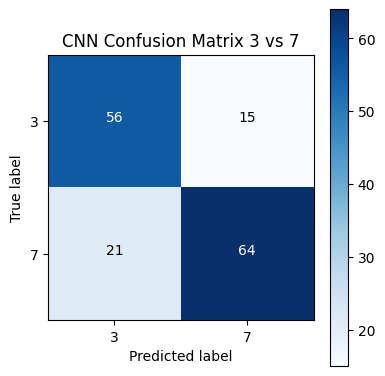


--- Evaluating pair 3 vs 8 ---
Evaluating NN on 3 vs 8


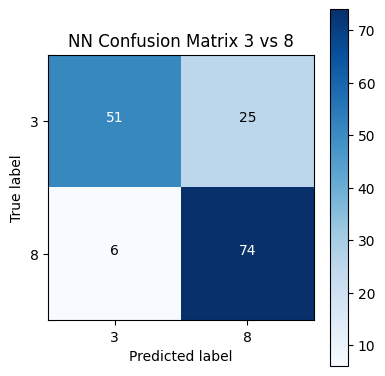

Evaluating MLP on 3 vs 8


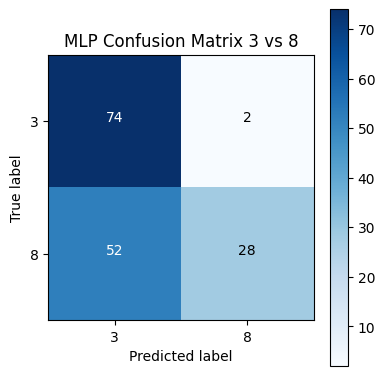

Evaluating CNN on 3 vs 8


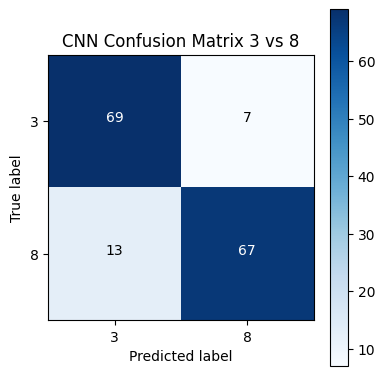


--- Evaluating pair 3 vs 9 ---
Evaluating NN on 3 vs 9


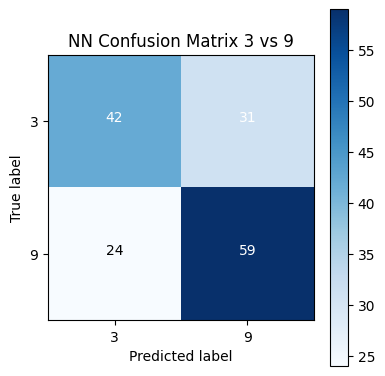

Evaluating MLP on 3 vs 9


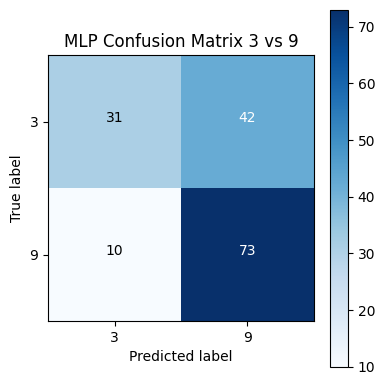

Evaluating CNN on 3 vs 9


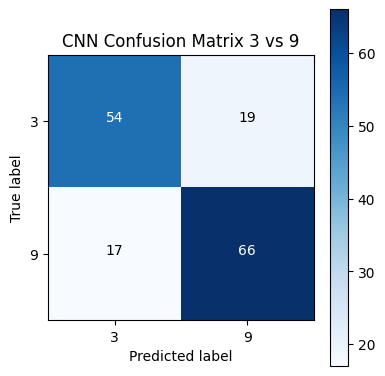


--- Evaluating pair 4 vs 5 ---
Evaluating NN on 4 vs 5


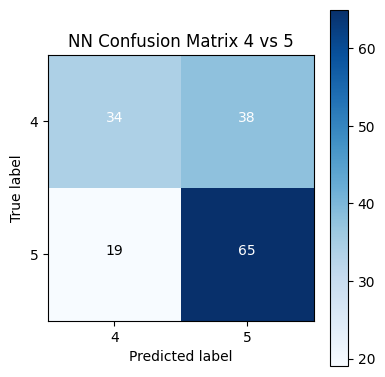

Evaluating MLP on 4 vs 5


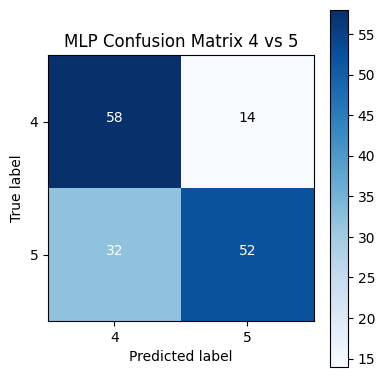

Evaluating CNN on 4 vs 5


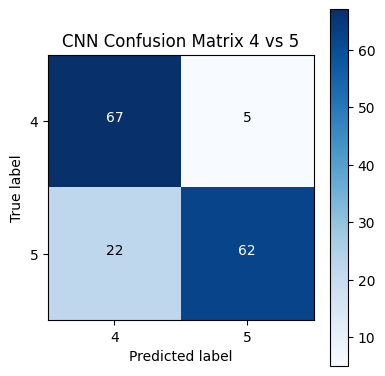


--- Evaluating pair 4 vs 6 ---
Evaluating NN on 4 vs 6


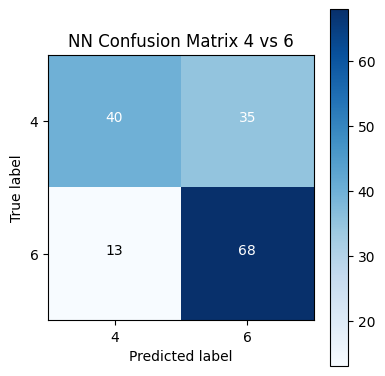

Evaluating MLP on 4 vs 6


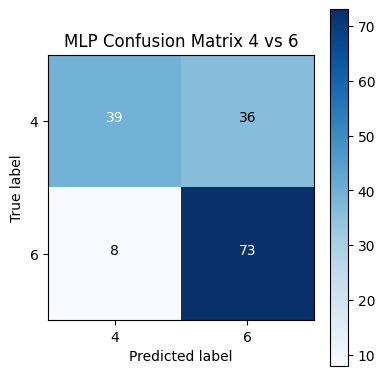

Evaluating CNN on 4 vs 6


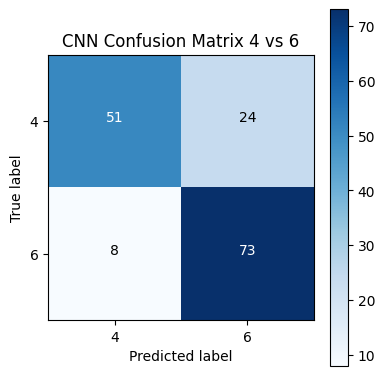


--- Evaluating pair 4 vs 7 ---
Evaluating NN on 4 vs 7


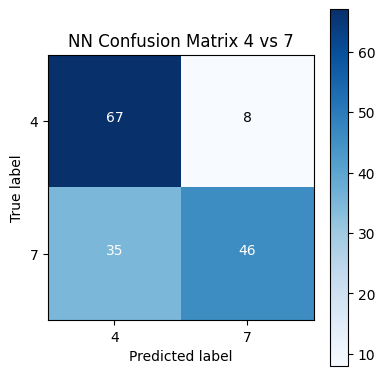

Evaluating MLP on 4 vs 7


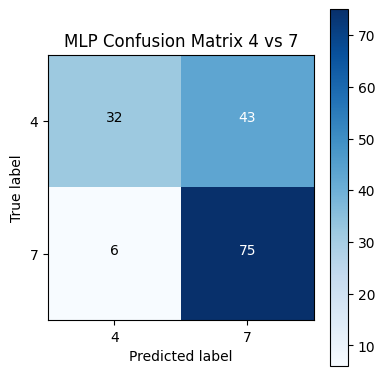

Evaluating CNN on 4 vs 7


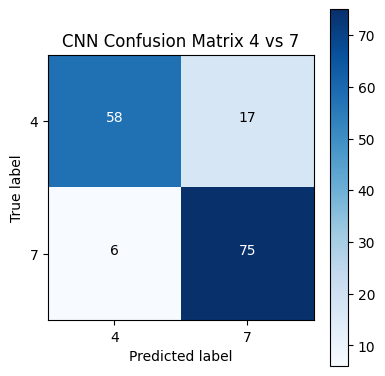


--- Evaluating pair 4 vs 8 ---
Evaluating NN on 4 vs 8


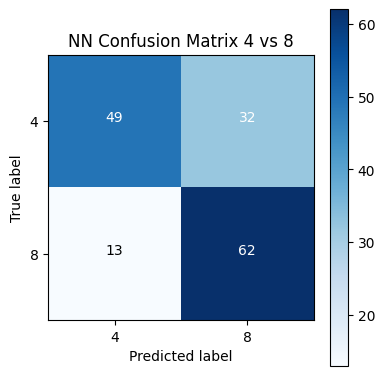

Evaluating MLP on 4 vs 8


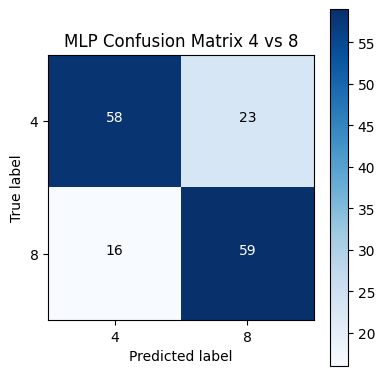

Evaluating CNN on 4 vs 8


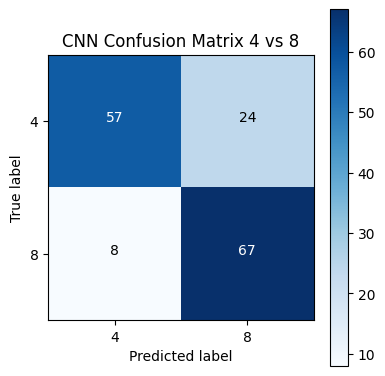


--- Evaluating pair 4 vs 9 ---
Evaluating NN on 4 vs 9


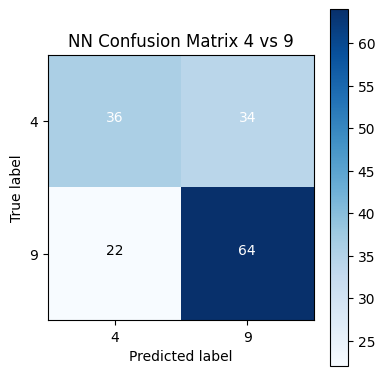

Evaluating MLP on 4 vs 9


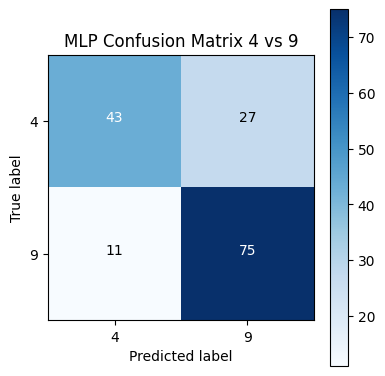

Evaluating CNN on 4 vs 9


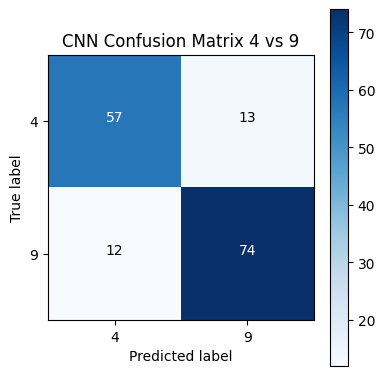


--- Evaluating pair 5 vs 6 ---
Evaluating NN on 5 vs 6


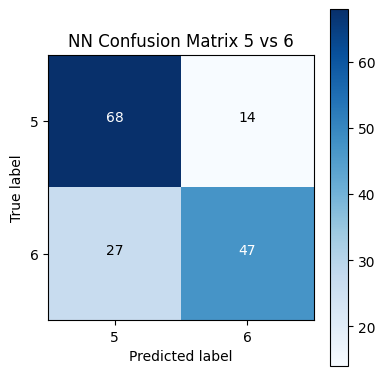

Evaluating MLP on 5 vs 6


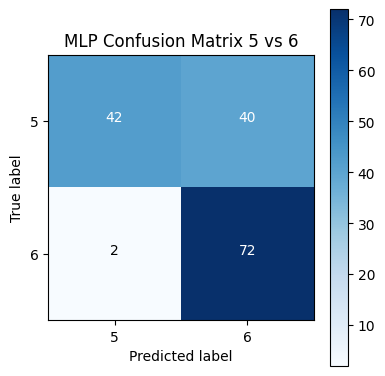

Evaluating CNN on 5 vs 6


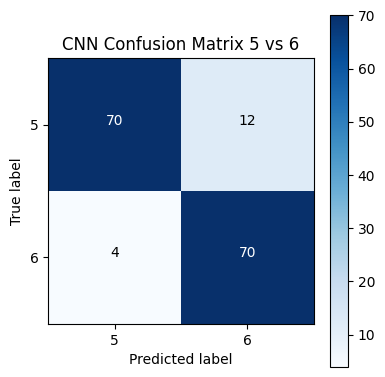


--- Evaluating pair 5 vs 7 ---
Evaluating NN on 5 vs 7


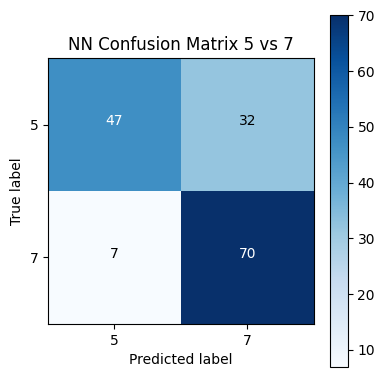

Evaluating MLP on 5 vs 7


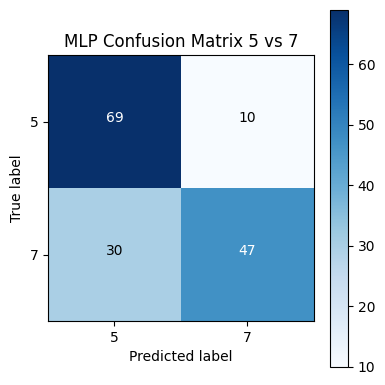

Evaluating CNN on 5 vs 7


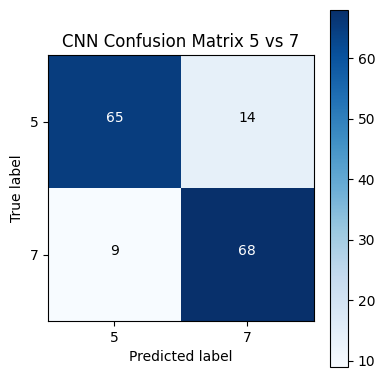


--- Evaluating pair 5 vs 8 ---
Evaluating NN on 5 vs 8


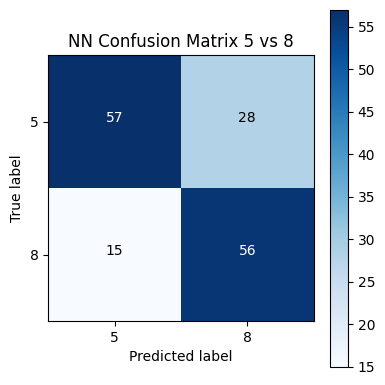

Evaluating MLP on 5 vs 8


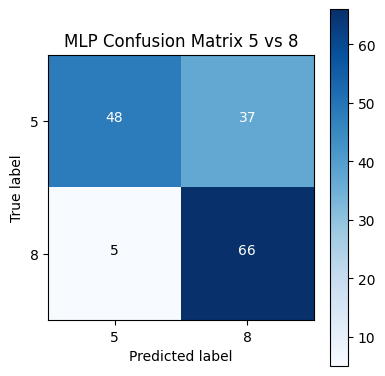

Evaluating CNN on 5 vs 8


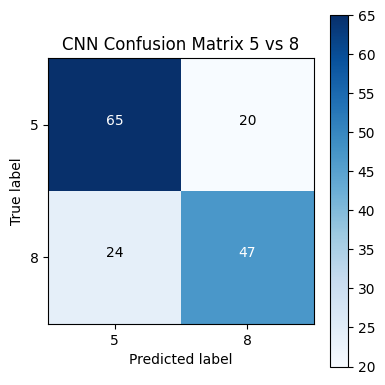


--- Evaluating pair 5 vs 9 ---
Evaluating NN on 5 vs 9


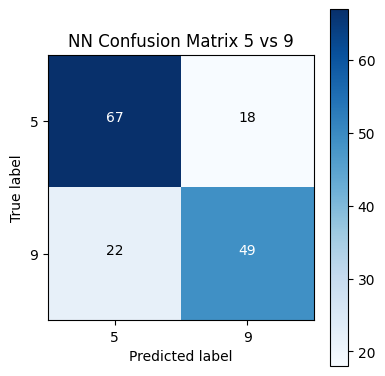

Evaluating MLP on 5 vs 9


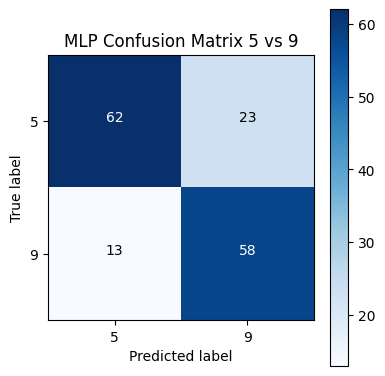

Evaluating CNN on 5 vs 9


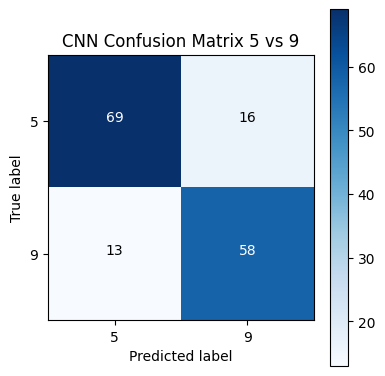


--- Evaluating pair 6 vs 7 ---
Evaluating NN on 6 vs 7


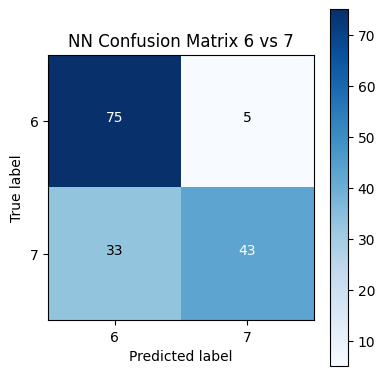

Evaluating MLP on 6 vs 7


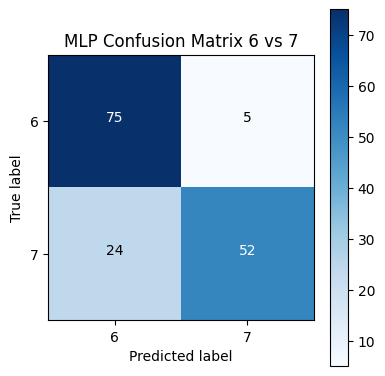

Evaluating CNN on 6 vs 7


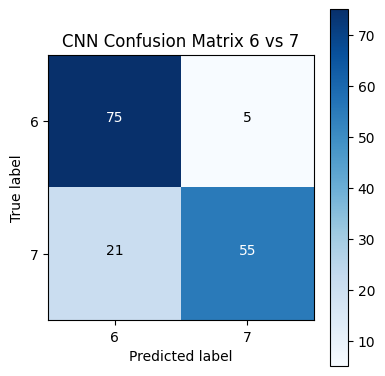


--- Evaluating pair 6 vs 8 ---
Evaluating NN on 6 vs 8


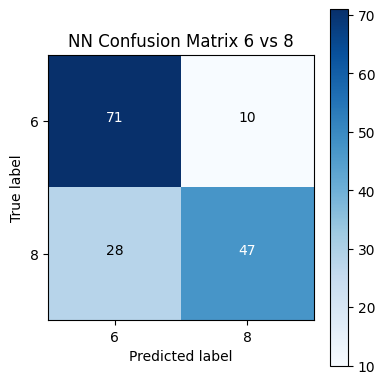

Evaluating MLP on 6 vs 8


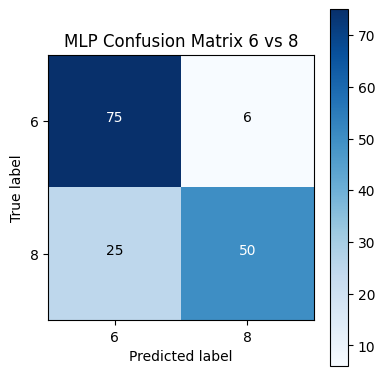

Evaluating CNN on 6 vs 8


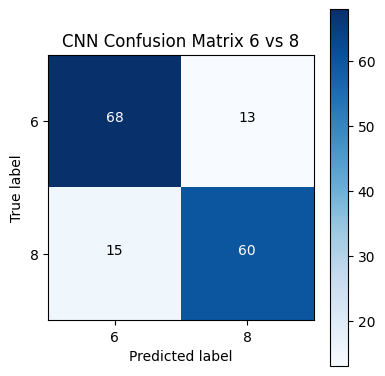


--- Evaluating pair 6 vs 9 ---
Evaluating NN on 6 vs 9


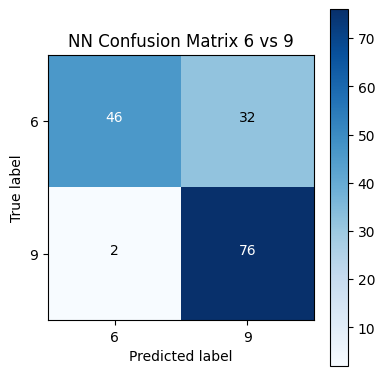

Evaluating MLP on 6 vs 9


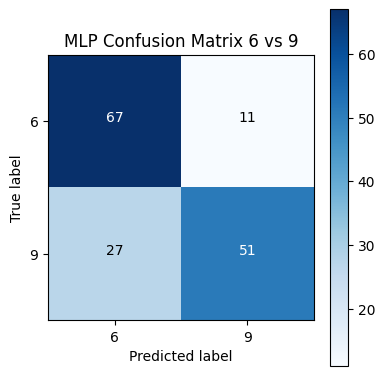

Evaluating CNN on 6 vs 9


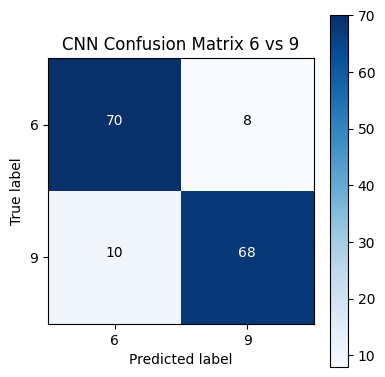


--- Evaluating pair 7 vs 8 ---
Evaluating NN on 7 vs 8


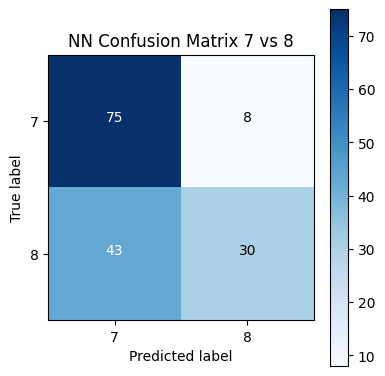

Evaluating MLP on 7 vs 8


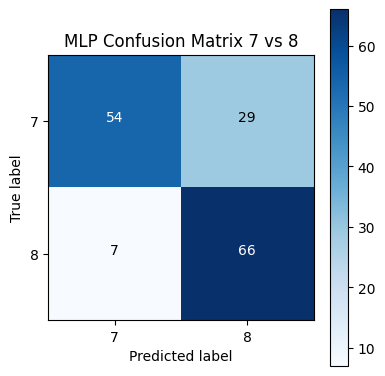

Evaluating CNN on 7 vs 8


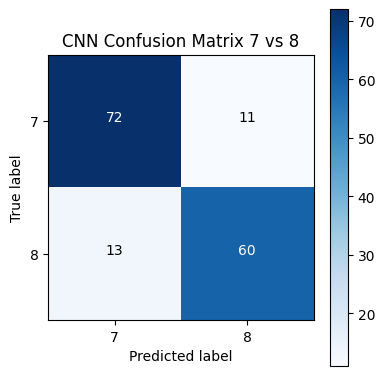


--- Evaluating pair 7 vs 9 ---
Evaluating NN on 7 vs 9


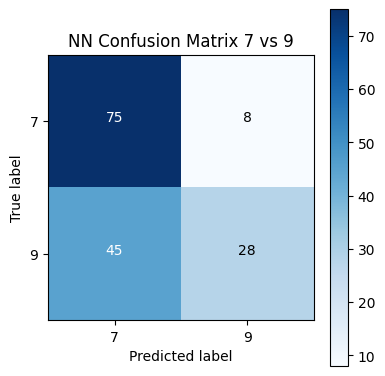

Evaluating MLP on 7 vs 9


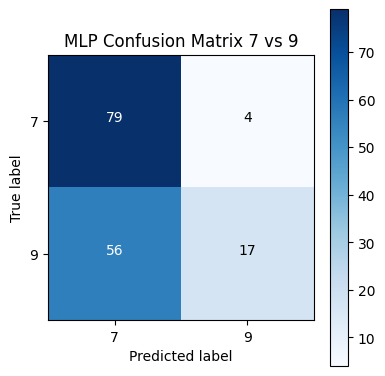

Evaluating CNN on 7 vs 9


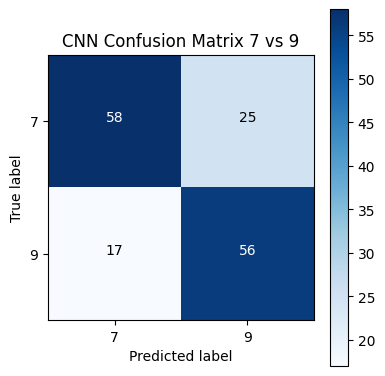


--- Evaluating pair 8 vs 9 ---
Evaluating NN on 8 vs 9


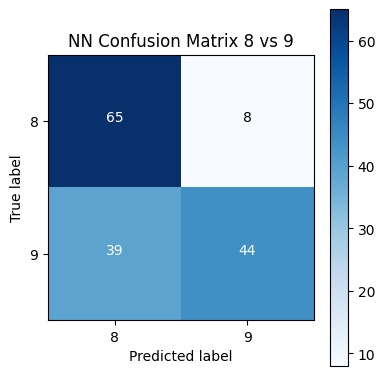

Evaluating MLP on 8 vs 9


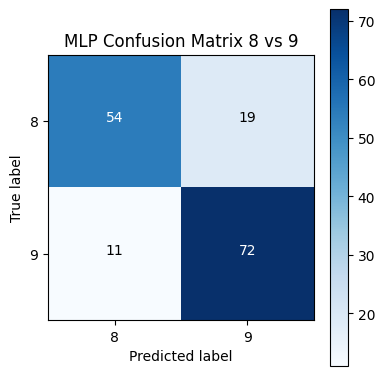

Evaluating CNN on 8 vs 9


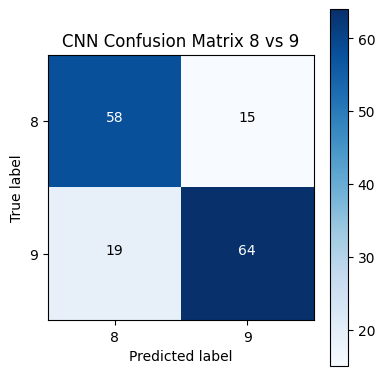

In [42]:
### START CODE HERE ###
from sklearn.metrics import confusion_matrix

def evaluate_confusion_matrix(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).int().squeeze()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Now load and evaluate all saved models:

for (class_a, class_b) in digit_pairs:
    print(f"\n--- Evaluating pair {class_a} vs {class_b} ---")
    classes_for_pair = [str(class_a), str(class_b)]
    
    # Load test loader again for this pair
    _, test_loader = load_data("thai-handwriting-number.appspot.com", classes_for_pair)
    
    for name, ModelClass in model_classes.items():
        print(f"Evaluating {name.upper()} on {class_a} vs {class_b}")
        
        model = ModelClass().to(device)
        checkpoint_path = f'checkpoints/{class_a}_vs_{class_b}_{name}.pth'
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        
        cm = evaluate_confusion_matrix(model, test_loader, device=device)
        plot_confusion_matrix(cm, classes=classes_for_pair, title=f'{name.upper()} Confusion Matrix {class_a} vs {class_b}')
### END CODE HERE ###

Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?<br>
ANS : CNN กราฟ accuracy ต่อ epoch ขึ้นแบบก้าวกระโดดกว่า model อื่น
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.<br>
ANS : 2v9 ดีสุด ส่วน 0v6 แย่สุด เพราะเลข 0 กับ 6 มีความคล้ายกัน
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.<br>
ANS : จาก dataset นี้ CNN ทำได้ดีกว่า CNN เหมาะกับโครงสร้างเชิงพื้นที่ เช่น รูปภาพ ส่วน NN/MLP เหมาะกับรูปแบบเวกเตอร์ เช่น ข้อมูลเชิงตาราง, ข้อมูล tabular
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.<br>
ANS : ควรเพิ่มชั้น Layer ให้มากขึ้น และทำ data augment ให้เห็นในหลายๆมุม
